In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.getcwd()

'/Users/blaubach/chimes_CGD-myLLFork/dissimilarity_clustering'

In [2]:
with open("dft_pds/2b_avg_pd_equilibrium", 'rb') as pickle_file:
    avg_pd_2b = pickle.load(pickle_file)

with open("dft_pds/3b_avg_pd_equilibrium", 'rb') as pickle_file:
    avg_pd_3b = pickle.load(pickle_file)

with open("dft_pds/4b_avg_pd_equilibrium", 'rb') as pickle_file:
    avg_pd_4b = pickle.load(pickle_file)

# Combine the arrays along the second axis (axis=1)
combined_array = np.concatenate((avg_pd_2b, avg_pd_3b, avg_pd_4b), axis=1)

# Verify the shape of the combined array
print(combined_array.shape)  # Output will be (12, 180, 1)

# Reshape the array to (12, 60) before creating the DataFrame
reshaped_data = np.array(combined_array).reshape(12, 180)

# Create a DataFrame
avg_df = pd.DataFrame(reshaped_data) # Ground Truth

(12, 180, 1)


Equilibrium Frames

In [3]:
with open("dft_pds/2b_all_pd_equilibrium", 'rb') as pickle_file:
    equil_pd_2b = pickle.load(pickle_file)

with open("dft_pds/3b_all_pd_equilibrium", 'rb') as pickle_file:
    equil_pd_3b = pickle.load(pickle_file)

with open("dft_pds/4b_all_pd_equilibrium", 'rb') as pickle_file:
    equil_pd_4b = pickle.load(pickle_file)

# Combine the arrays along the second axis (axis=1)
all_array = np.concatenate((equil_pd_2b, equil_pd_3b, equil_pd_4b), axis=2)
print(np.shape(all_array))
all_array = all_array.reshape(-1,all_array.shape[2])
print(np.shape(all_array))

# Create labels array
# Define the maximum number of repetitions for each number
max_repetitions = 13
# Define the range of numbers from 0 to 11
numbers_range = np.arange(12)
# Create the array
labels = np.repeat(numbers_range, max_repetitions)
print(np.shape(labels))
all_equilibrium_df = pd.DataFrame(all_array)

(12, 13, 180)
(156, 180)
(156,)


All Frames

In [4]:
with open("dft_pds/2b_all_pd", 'rb') as pickle_file:
    pd_2b = pickle.load(pickle_file)

with open("dft_pds/3b_all_pd", 'rb') as pickle_file:
    pd_3b = pickle.load(pickle_file)

with open("dft_pds/4b_all_pd", 'rb') as pickle_file:
    pd_4b = pickle.load(pickle_file)

# Combine the arrays along the second axis (axis=1)
all_array = np.concatenate((pd_2b, pd_3b, pd_4b), axis=2)
all_array = all_array.reshape(-1,all_array.shape[2])

# Create labels array
# Define the maximum number of repetitions for each number
max_repetitions = 25
# Define the range of numbers from 0 to 11
numbers_range = np.arange(12)
# Create the array
labels = np.repeat(numbers_range, max_repetitions)
all_df = pd.DataFrame(all_array)
all_df['labels'] = labels
all_df.fillna(0, inplace=True)
all_df.drop(columns=['labels'], inplace=True)
print(all_df.shape)

(300, 180)


Compute KL Divergence

0     0.184378
1     0.090387
2     0.082596
3     0.026297
4     0.018981
5     0.009174
6     0.025555
7     0.016832
8     0.010479
9     0.026986
10    0.000820
11    0.014562
12    0.028855
13    0.000990
14    0.002495
15    0.001295
16    0.006050
17    0.006011
18    0.012087
19    0.005642
20    0.002556
21    0.002902
22    0.016157
23    0.011005
24    0.013935
dtype: float64


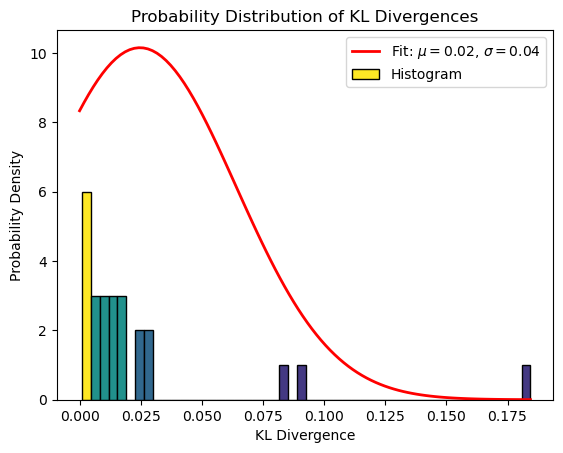

ValueError: operands could not be broadcast together with shapes (25,) (50,) 

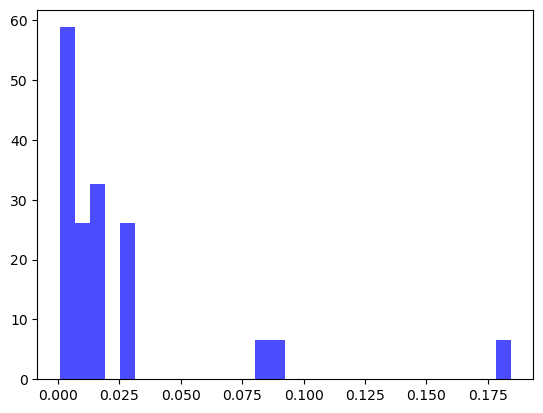

In [12]:
import pandas as pd
from scipy.stats import entropy
from scipy.stats import norm, lognorm
from scipy.optimize import curve_fit

# https://datascience.stackexchange.com/questions/9262/calculating-kl-divergence-in-python
def KL(a, b, epsilon=1e-10):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)

    # Add epsilon to the probabilities to avoid division by zero
    a += epsilon
    b += epsilon

    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

# Take the first 13 rows of df1
#df1_first_13 = all_equilibrium_df.iloc[:13]
df1_first_13 = all_df.iloc[:25]

# Take the first row of df2
reference_row = avg_df.iloc[0]
avg_df
# Compute KL divergence for each row in df1_first_13 relative to reference_row
kl_divergences = []
for index, row in df1_first_13.iterrows():
    kl_divergence = entropy(row, reference_row)
    kl_divergences.append(kl_divergence)

# Convert the list of KL divergences to a pandas Series
kl_divergences_series = pd.Series(kl_divergences, index=df1_first_13.index)

print(kl_divergences_series)

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import viridis
from scipy.stats import norm
from scipy.optimize import curve_fit

# Define the number of bins
num_bins = 50

# Calculate histogram without plotting to get bin counts
counts, bins = np.histogram(kl_divergences_series, bins=num_bins)

# Get the bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Normalize counts to [0, 1]
counts_normalized = counts / counts.max()

# Generate colors using Viridis colormap
colors = viridis(counts_normalized)

# Generate colors using Viridis colormap
colors = viridis(counts_normalized)

# Plot a histogram of KL divergences
plt.bar(bin_centers, counts, width=np.diff(bins), color=colors, edgecolor='black', label='Histogram')

# Fit a normal distribution to the positive side of the data
positive_data = kl_divergences_series[kl_divergences_series > 0]

# Calculate the midpoint index
midpoint_index = len(positive_data) // 2

# Take the last half of the values
last_half_positive_data = positive_data[midpoint_index:]

# Fit a normal distribution to positive side
mu, std = norm.fit(positive_data)
mu_equil, std_equil = norm.fit(last_half_positive_data)

# Plot the continuous probability distribution
x = np.linspace(0, positive_data.max(), 100)
x_equil = np.linspace(0, last_half_positive_data.max(), 100)
plt.plot(x, norm.pdf(x, mu, std), 'r-', linewidth=2, label=f'Fit: $\mu={mu:.2f}$, $\sigma={std:.2f}$')
#plt.plot(x_equil, norm.pdf(x_equil, mu_equil, std_equil), 'r-', linewidth=2, label=f'Fit: $\mu={mu_equil:.2f}$, $\sigma={std_equil:.2f}$')

plt.title('Probability Distribution of KL Divergences')
plt.xlabel('KL Divergence')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

Frames:  0  to  25
0     0.544545
1     0.266641
2     0.243578
3     0.079571
4     0.057167
5     0.026525
6     0.074865
7     0.050523
8     0.031939
9     0.078980
10    0.001981
11    0.044327
12    0.084611
13    0.002593
14    0.006563
15    0.003526
16    0.018105
17    0.016988
18    0.036632
19    0.016004
20    0.007419
21    0.009257
22    0.047149
23    0.033926
24    0.040583
dtype: float64


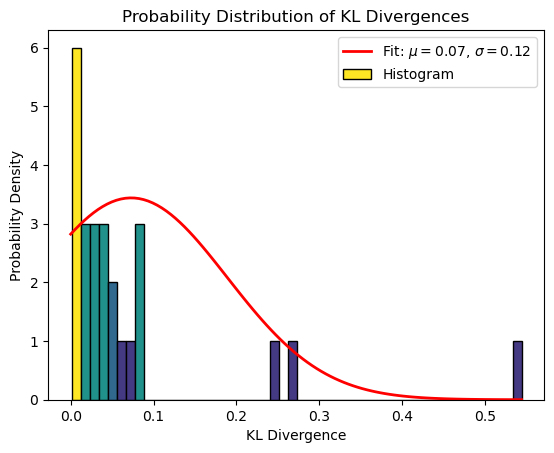

Frames:  25  to  50
25    0.692664
26    0.021844
27    0.002678
28    0.000798
29    0.001276
30    0.001454
31    0.000109
32    0.000466
33    0.000459
34    0.000973
35    0.000376
36    0.000532
37    0.000068
38    0.000697
39   -0.000111
40   -0.000201
41    0.000409
42    0.000196
43    0.001055
44    0.000220
45    0.000618
46    0.000485
47    0.000592
48    0.000416
49   -0.000022
dtype: float64


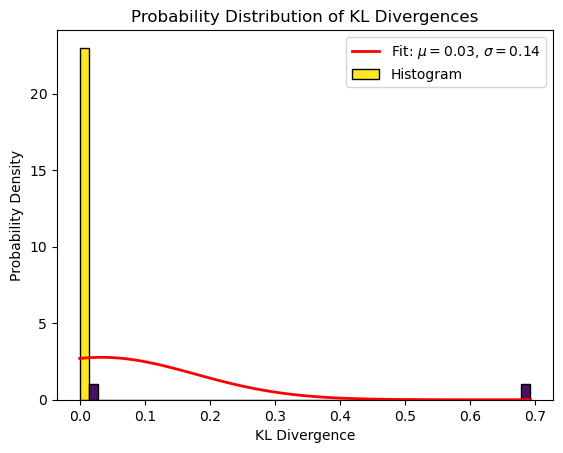

Frames:  50  to  75
50    1.719994
51    0.122012
52    0.191530
53    0.013167
54    0.049879
55    0.204758
56    0.116069
57    0.070573
58    0.019292
59    0.010085
60    0.034283
61    0.026739
62    0.027398
63    0.016714
64    0.033491
65    0.014530
66    0.020167
67    0.011947
68    0.033228
69    0.042125
70    0.016283
71    0.008106
72    0.034435
73    0.025529
74    0.022882
dtype: float64


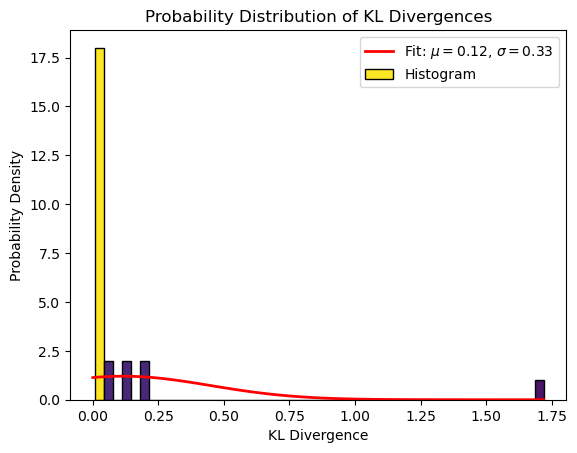

Frames:  75  to  100
75    1.657231
76    0.011980
77    0.005971
78    0.004241
79   -0.001269
80    0.011294
81    0.007934
82    0.001822
83    0.013449
84    0.003123
85    0.010934
86    0.009925
87    0.004892
88    0.002736
89    0.007921
90    0.001049
91    0.005043
92    0.005833
93    0.005136
94    0.010791
95    0.000595
96    0.005251
97    0.009209
98    0.006878
99    0.004756
dtype: float64


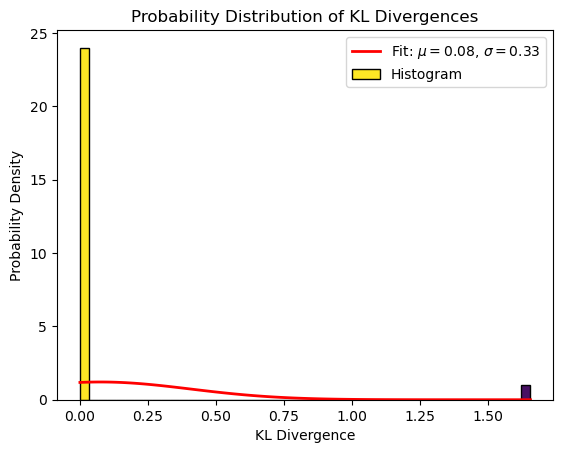

Frames:  100  to  125
100    0.475418
101    0.005820
102    0.002622
103    0.000118
104    0.007825
105   -0.000359
106    0.006235
107    0.010388
108    0.001224
109    0.002137
110    0.001730
111   -0.001364
112    0.007666
113    0.004472
114    0.002387
115    0.003310
116    0.003071
117   -0.001748
118    0.011091
119    0.003319
120   -0.000342
121    0.002523
122    0.004854
123    0.001440
124    0.004241
dtype: float64


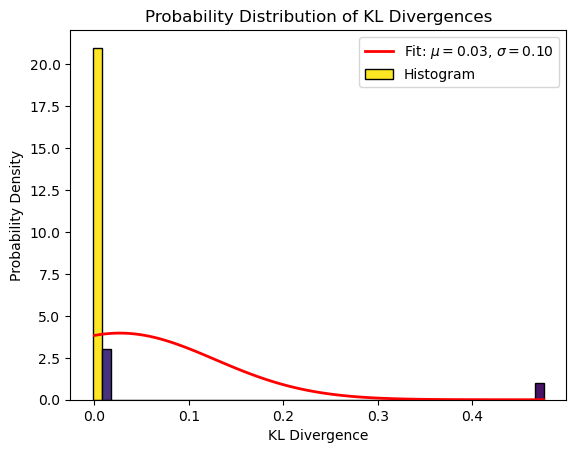

Frames:  125  to  150
125    0.016726
126   -0.000678
127   -0.000032
128    0.000091
129    0.000527
130    0.000818
131    0.000092
132    0.000219
133   -0.000621
134    0.000221
135    0.000372
136    0.000533
137    0.000625
138    0.000330
139    0.000033
140    0.000786
141   -0.000453
142    0.000538
143   -0.000532
144   -0.000382
145    0.000924
146    0.000411
147    0.000942
148    0.000108
149    0.000070
dtype: float64


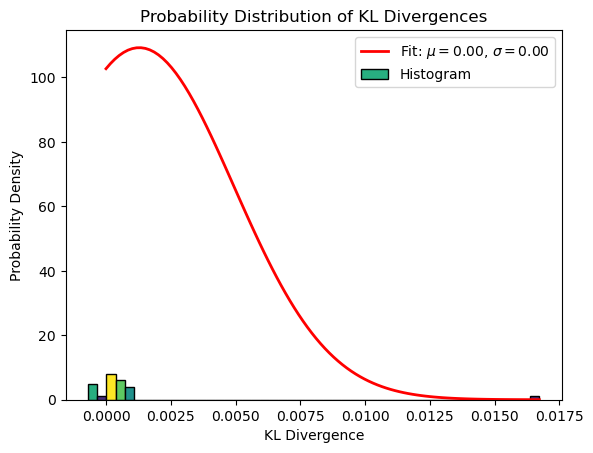

Frames:  150  to  175
150    0.110799
151    0.001879
152    0.000994
153   -0.000764
154    0.001949
155    0.002476
156   -0.001020
157    0.006063
158   -0.001690
159    0.001164
160    0.000929
161    0.000813
162    0.008295
163    0.002360
164    0.004868
165   -0.000615
166   -0.002372
167    0.001364
168   -0.002698
169    0.005518
170    0.001890
171    0.000452
172    0.001408
173    0.005061
174    0.007001
dtype: float64


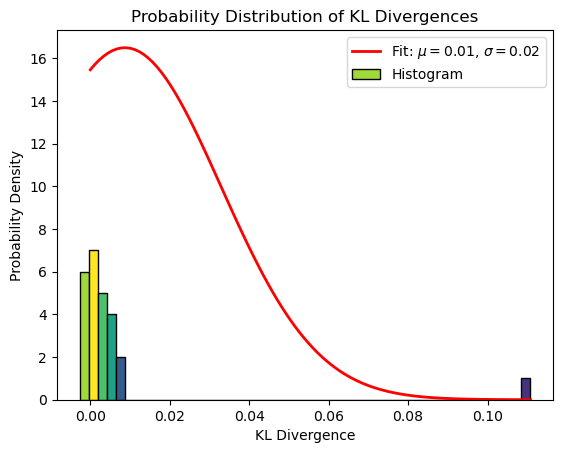

Frames:  175  to  200
175    0.592514
176    0.261973
177    0.198751
178    0.011881
179    0.114629
180    0.082182
181    0.078316
182    0.061631
183    0.042176
184    0.084568
185    0.040171
186    0.041914
187    0.071527
188    0.019048
189    0.074145
190    0.004104
191    0.028403
192    0.060876
193    0.008052
194    0.023623
195    0.059095
196    0.047404
197    0.005986
198    0.026447
199    0.051571
dtype: float64


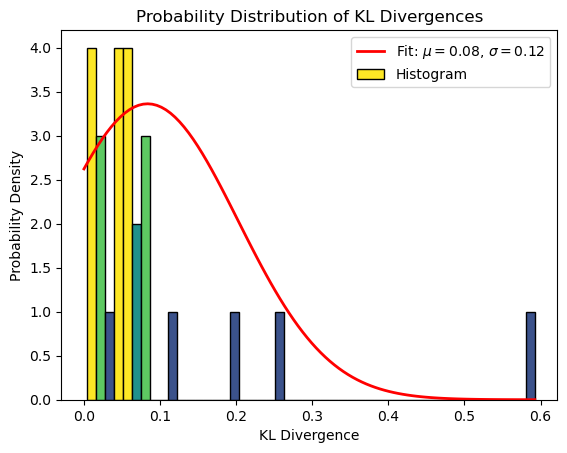

Frames:  200  to  225
200    0.531122
201    0.005095
202    0.012041
203    0.006110
204    0.001300
205    0.000407
206    0.003786
207    0.001926
208    0.000248
209    0.000673
210    0.000773
211    0.001676
212    0.000547
213    0.000580
214    0.001207
215    0.000463
216    0.003789
217    0.001910
218    0.000241
219    0.000532
220    0.000778
221    0.001695
222    0.000546
223    0.000584
224    0.001233
dtype: float64


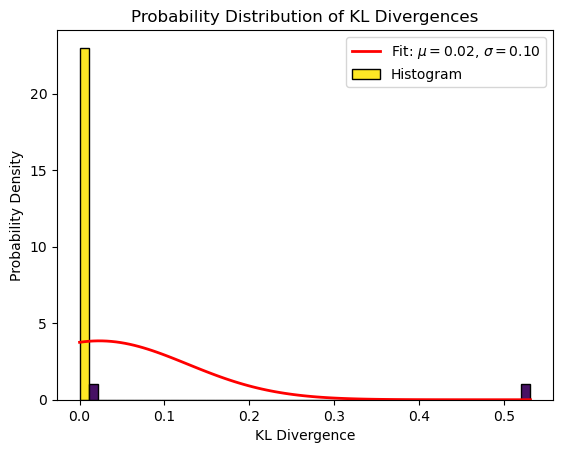

Frames:  225  to  250
225    0.702056
226    0.015921
227    0.004255
228    0.001951
229    0.010843
230    0.000004
231    0.000313
232    0.001560
233    0.000577
234    0.000839
235    0.000682
236    0.000268
237    0.003618
238    0.000433
239    0.000634
240    0.000702
241    0.000415
242    0.001987
243    0.000698
244    0.000547
245    0.001228
246    0.000245
247    0.002961
248    0.000407
249    0.000706
dtype: float64


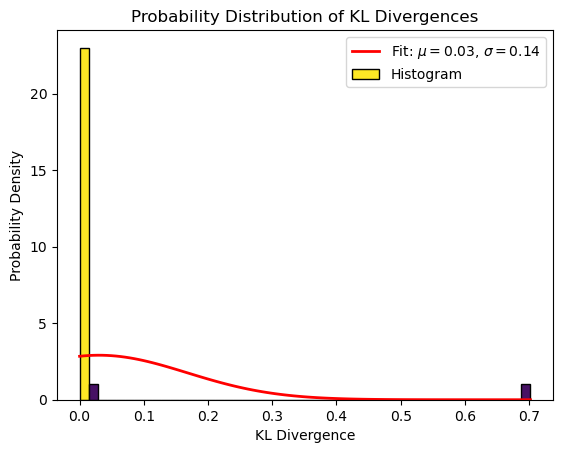

Frames:  250  to  275
250    0.454026
251    0.004050
252    0.006977
253   -0.000337
254    0.005667
255    0.000022
256    0.004194
257    0.000225
258   -0.000456
259   -0.000627
260    0.002779
261    0.002557
262   -0.001485
263    0.000710
264    0.005244
265    0.000853
266   -0.001493
267    0.001838
268    0.014846
269    0.000973
270    0.004391
271    0.002379
272    0.002123
273    0.000345
274   -0.000812
dtype: float64


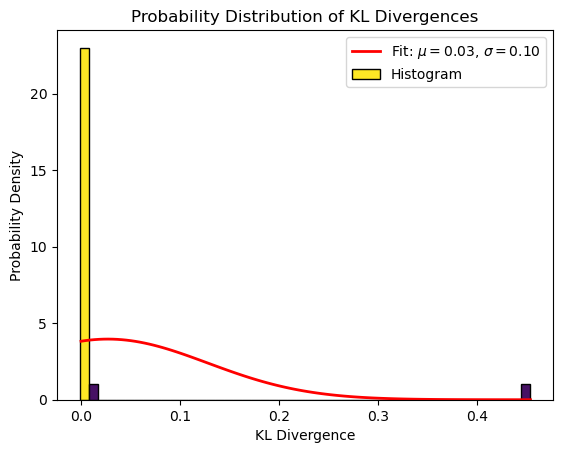

Frames:  275  to  300
275    0.004121
276    0.002059
277   -0.000391
278   -0.000657
279    0.000053
280    0.004885
281    0.002065
282   -0.000804
283    0.003347
284    0.001557
285    0.000705
286   -0.000924
287    0.001179
288   -0.000276
289    0.001959
290    0.000808
291   -0.000230
292    0.001569
293    0.000885
294    0.000633
295   -0.000590
296   -0.000669
297    0.000052
298    0.007110
299    0.001365
dtype: float64


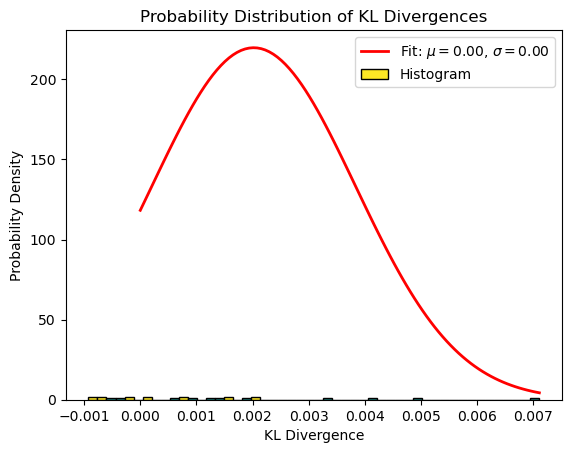

In [13]:
import pandas as pd
from scipy.stats import entropy
from scipy.stats import norm
from scipy.optimize import curve_fit

# https://datascience.stackexchange.com/questions/9262/calculating-kl-divergence-in-python
def KL(a, b, epsilon=1e-10):
    a = np.asarray(a)
    b = np.asarray(b)

    # Add epsilon to the probabilities to avoid division by zero
    a += epsilon
    b += epsilon

    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

start_frame = 0
for i in range(len(avg_df)):
    end_frame = start_frame + 25
    print("Frames: ",start_frame," to ", end_frame)
    # Take the first 13 rows of df1
    #df1_first_13 = all_equilibrium_df.iloc[:13]
    df1_first_13 = all_df.iloc[start_frame:end_frame]

    # Take the first row of df2
    reference_row = avg_df.iloc[i]
    avg_df
    # Compute KL divergence for each row in df1_first_13 relative to reference_row
    kl_divergences = []
    for index, row in df1_first_13.iterrows():
        kl_divergence = entropy(row, reference_row)
        #kl_divergences.append(kl_divergence)
        kl_divergences.append(KL(row, reference_row))

    # Convert the list of KL divergences to a pandas Series
    kl_divergences_series = pd.Series(kl_divergences, index=df1_first_13.index)
    print(kl_divergences_series)

    # Define the number of bins
    num_bins = 50

    # Calculate histogram without plotting to get bin counts
    counts, bins = np.histogram(kl_divergences_series, bins=num_bins)

    # Get the bin centers
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Normalize counts to [0, 1]
    counts_normalized = counts / counts.max()

    # Generate colors using Viridis colormap
    colors = viridis(counts_normalized)

    # Plot a histogram of KL divergences
    plt.bar(bin_centers, counts, width=np.diff(bins), color=colors, edgecolor='black', label='Histogram')

    # Fit a normal distribution to the positive side of the data
    positive_data = kl_divergences_series[kl_divergences_series > 0]

    # Calculate the midpoint index
    midpoint_index = len(positive_data) // 2

    # Take the last half of the values
    last_half_positive_data = positive_data[midpoint_index:]

    # Fit a normal distribution to positive side
    mu, std = norm.fit(positive_data)
    mu_equil, std_equil = norm.fit(last_half_positive_data)

    # Plot the continuous probability distribution
    x = np.linspace(0, positive_data.max(), 100)
    x_equil = np.linspace(0, last_half_positive_data.max(), 100)
    plt.plot(x, norm.pdf(x, mu, std), 'r-', linewidth=2, label=f'Fit: $\mu={mu:.2f}$, $\sigma={std:.2f}$')
    #plt.plot(x_equil, norm.pdf(x_equil, mu_equil, std_equil), 'r-', linewidth=2, label=f'Fit: $\mu={mu_equil:.2f}$, $\sigma={std_equil:.2f}$')

    plt.title('Probability Distribution of KL Divergences')
    plt.xlabel('KL Divergence')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.show()
    start_frame += 25



In [ ]:
all_df.loc[50]

0      0.229160
1      0.141165
2      0.082895
3      0.043521
4      0.021554
         ...   
175    0.000000
176    0.000000
177    0.000000
178    0.000000
179    0.000000
Name: 50, Length: 180, dtype: float64